In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'utkface-new:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F44109%2F78156%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240403%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240403T025859Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3De1ecbcce20519f603a484d3dbbbc9d7a0cc551eb030385d45c52dd8575be5f34eb051b055f537e5454507ae1ee0824600648584e6dd4ca9fa9e96ce710545c55b9c361ad22ed34fcac35091b12e3a329249c742671d3eca5c99c05f37eadf5a45b88a9b6143b4c103379386044364392a85903b40c10c164ddfdbb2ccecfac59df993746b02bb0ff426e5dd5946ebe6ce65e185d2fdf61028ae1fc219dd5067a2e83953505319f86ed7e76467ba3f5509a1ef89402e149f230d048d1440863515b5987ea52bccac9a2254560bc6d56bcb368a44a505e9a4e03874db0fa48f900557c5e49599ffbaaed0ee83e418a1f1599d65ff1e75fe6102edcaf5a4af70132'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'



!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 347342542 bytes downloaded
Downloaded and uncompressed: utkface-new
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

Format of the file: age_gender_ethnicity_datetime

In [ ]:
path = "/kaggle/input/utkface-new/UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
35_0_0_20170117120013930.jpg.chip.jpg


In [ ]:
import cv2
images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]) )

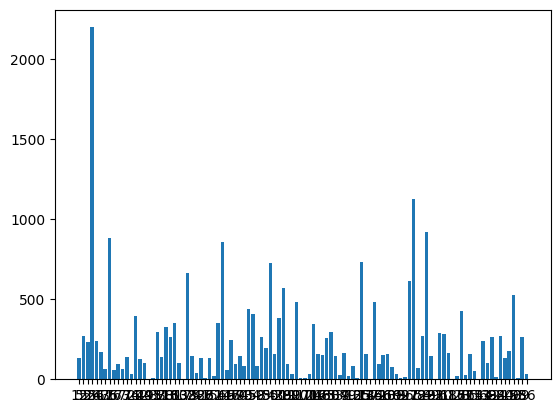

Max value: 99


In [ ]:
import matplotlib.pyplot as plt
x_ages = list(set(ages))
y_ages = [ages.count(i) for i in x_ages]
plt.bar(x_ages,y_ages)
plt.show()
print("Max value:",max(ages))

Gender: 1 Age: 26


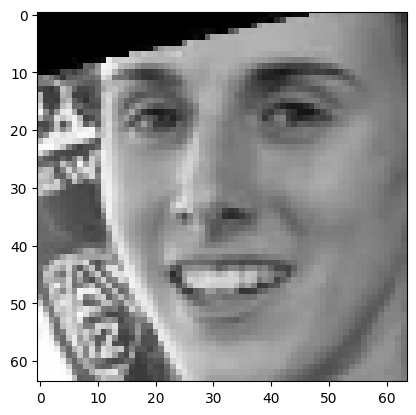

In [ ]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
idx = 500
sample = images[idx]
print("Gender:",genders[idx],"Age:",ages[idx])
display(sample)

In [ ]:
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

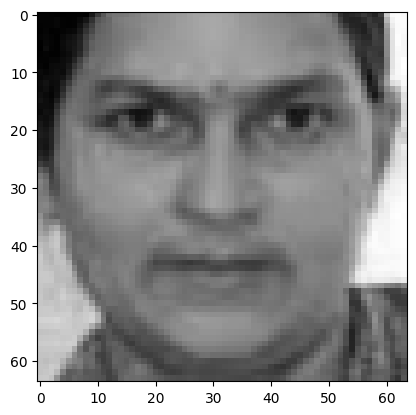

In [ ]:
# pre processing
target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 4
    target[i,1] = int(genders[i])
    features[i] = images[i]
features = features / 255
display(features[550])

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 18966
Samples in Testing: 4742


In [ ]:
print("Shape of image:",sample.shape)

Shape of image: (64, 64, 1)


In [ ]:
import keras
from keras.layers import *
from keras.models import *
from keras import backend as K

In [ ]:
inputs = Input(shape=(64,64,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

In [ ]:
model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 62, 62, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 60, 60, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 30, 30, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
h = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),epochs = 25, batch_size=128,shuffle = True)

Epoch 1/25
149/149 [==============================] - 467s 3s/step - loss: 0.7867 - dense_3_loss: 0.0951 - dense_9_loss: 0.6916 - dense_3_accuracy: 0.0151 - dense_9_accuracy: 0.5109 - val_loss: 0.7050 - val_dense_3_loss: 0.0301 - val_dense_9_loss: 0.6749 - val_dense_3_accuracy: 0.0236 - val_dense_9_accuracy: 0.5356
Epoch 2/25
149/149 [==============================] - 449s 3s/step - loss: 0.6634 - dense_3_loss: 0.0496 - dense_9_loss: 0.6137 - dense_3_accuracy: 0.0210 - dense_9_accuracy: 0.6974 - val_loss: 0.5189 - val_dense_3_loss: 0.0248 - val_dense_9_loss: 0.4941 - val_dense_3_accuracy: 0.0238 - val_dense_9_accuracy: 0.8092
Epoch 3/25
149/149 [==============================] - 447s 3s/step - loss: 0.5811 - dense_3_loss: 0.0409 - dense_9_loss: 0.5402 - dense_3_accuracy: 0.0236 - dense_9_accuracy: 0.7860 - val_loss: 0.4689 - val_dense_3_loss: 0.0219 - val_dense_9_loss: 0.4471 - val_dense_3_accuracy: 0.0243 - val_dense_9_accuracy: 0.8342
Epoch 4/25
149/149 [=============================

In [ ]:
model.save('data.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


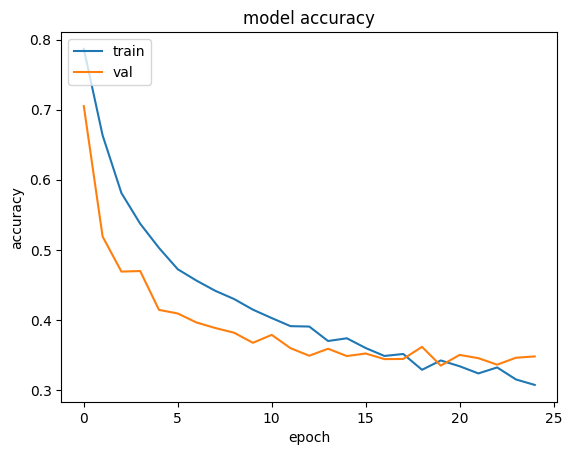

In [ ]:
history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

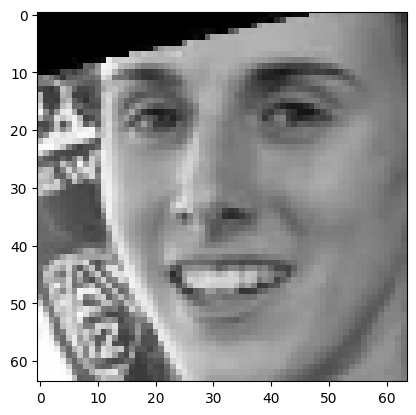

Actual Gender: Female Age: 26
1/1 [==============================] - 1s 818ms/step
Values: [array([[0.5950545]], dtype=float32), array([[0.8395297]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


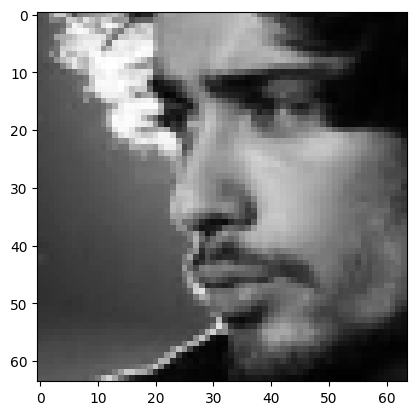

Actual Gender: Male Age: 28
1/1 [==============================] - 0s 48ms/step
Values: [array([[0.4916133]], dtype=float32), array([[2.1471321e-06]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 19-30


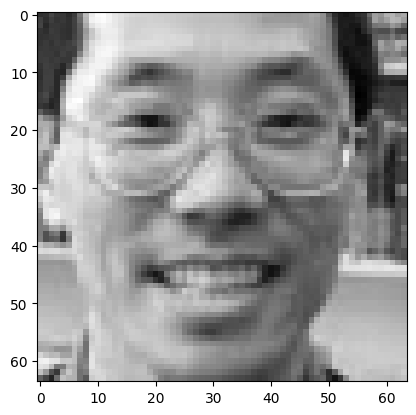

Actual Gender: Male Age: 40
1/1 [==============================] - 0s 46ms/step
Values: [array([[0.57779866]], dtype=float32), array([[1.0397162e-08]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 19-30


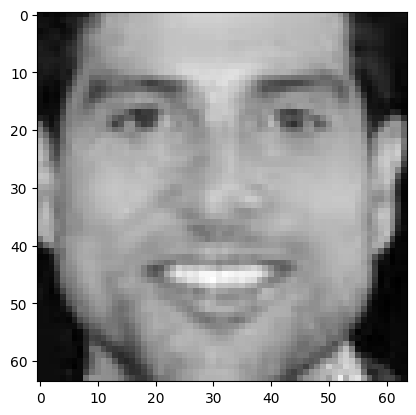

Actual Gender: Male Age: 26
1/1 [==============================] - 0s 82ms/step
Values: [array([[0.5880269]], dtype=float32), array([[4.3669214e-11]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 19-30


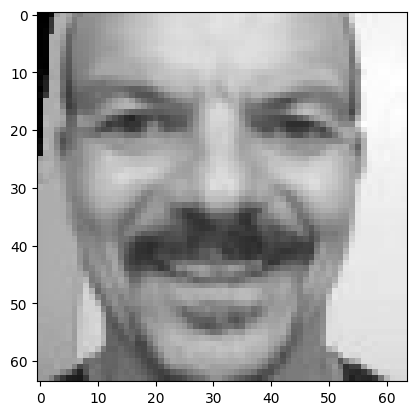

Actual Gender: Male Age: 56
1/1 [==============================] - 0s 58ms/step
Values: [array([[0.71835953]], dtype=float32), array([[1.02371535e-13]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


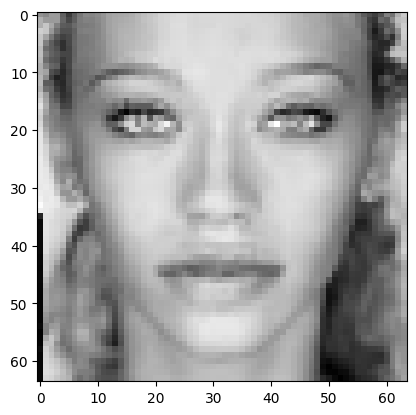

Actual Gender: Female Age: 25
1/1 [==============================] - 0s 63ms/step
Values: [array([[0.57893527]], dtype=float32), array([[0.8395297]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


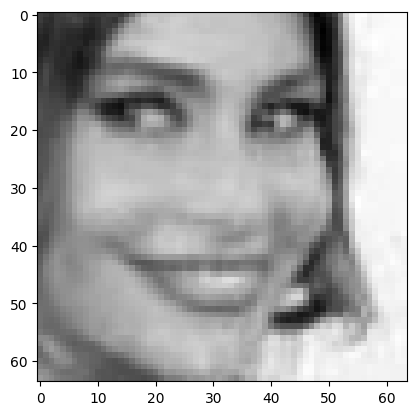

Actual Gender: Female Age: 41
1/1 [==============================] - 0s 138ms/step
Values: [array([[0.57779866]], dtype=float32), array([[0.8395297]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


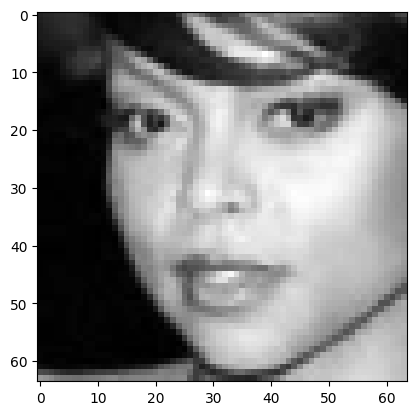

Actual Gender: Female Age: 38
1/1 [==============================] - 0s 30ms/step
Values: [array([[0.5513116]], dtype=float32), array([[0.8395297]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


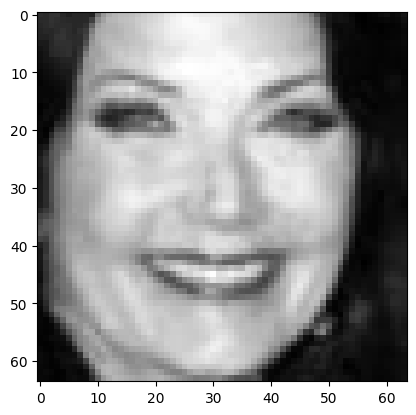

Actual Gender: Female Age: 35
1/1 [==============================] - 0s 48ms/step
Values: [array([[0.6721122]], dtype=float32), array([[0.8395297]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 31-80


In [ ]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()

def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"

def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict( np.array([ sample ]) )
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values:",val,"\nPredicted Gender:",gender,"Predicted Age:",age)


indexes = [500,59,80,2,4546,7,9,256,45]
for idx in indexes:
    sample = images[idx]
    display(sample)
    print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
    res = get_result(sample)